# Token Evaporation Tracking

**Testing the "one token kicks per step" hypothesis.**

At each training step, we look at the gradient updates (step-to-step embedding changes). Any token that receives an update with L2 norm > threshold gets **permanently masked out** as "escaped." We then track only the **remaining core** to see:

1. **Escape rate:** How many tokens escape per step?
2. **Core cohesion:** Does the remaining cluster stay tight?
3. **Deterministic vs thermal:** One token/step (deterministic) or many (stochastic)?

## Hypothesis

If training is deterministic "right token gets kicked":
- Expect ~1 escape per step
- Core should stay coherent (remaining tokens barely move)
- Escape pattern should be predictable

If thermal/chaotic:
- Multiple escapes per step, or bursty/irregular
- Core fragments (even non-escaped tokens drift)
- Unpredictable pattern

## Parameters

In [51]:
# Data source
TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9d_training_data.safetensors'
RUN_NAME = '1.9d (vanilla SGD, lr=0.1, batch=1)'

# Analysis window
ANALYSIS_STEPS = list(range(0, 101))  # Steps 0-100

# Escape threshold
L2_THRESHOLD = 0.005  # Token escapes if single-step update L2 norm > this

# Visualization
DPI = 200
COLORMAP = 'inferno'

## Imports

In [52]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt

## Device Detection

In [53]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [54]:
data = load_file(TRAINING_DATA_PATH)
embeddings = data['embeddings']  # (n_steps, 128, 64)

print(f'Loaded: {RUN_NAME}')
print(f'Embeddings shape: {embeddings.shape}')
print(f'Steps available: {embeddings.shape[0]}')
print(f'Analyzing steps: {ANALYSIS_STEPS[0]}-{ANALYSIS_STEPS[-1]}')
print(f'Escape threshold (L2): {L2_THRESHOLD}')

Loaded: 1.9d (vanilla SGD, lr=0.1, batch=1)
Embeddings shape: torch.Size([1001, 128, 64])
Steps available: 1001
Analyzing steps: 0-100
Escape threshold (L2): 0.005


## Track Escapes

In [55]:
print('Tracking token escapes...')
print()

n_tokens = embeddings.shape[1]
n_steps = len(ANALYSIS_STEPS)

# Mask: True = still in core, False = escaped
in_core = np.ones(n_tokens, dtype=bool)

# Storage
escape_log = []  # List of dicts: {step, token_idx, update_norm}
core_size_over_time = []
core_radius_over_time = []
escapes_per_step = []

for i, step in enumerate(ANALYSIS_STEPS):
    if i == 0:
        # Initial state: all tokens in core
        core_size_over_time.append(in_core.sum())
        
        # Compute initial core radius
        emb = embeddings[step].cpu().numpy()
        core_emb = emb[in_core]
        centroid = core_emb.mean(axis=0)
        radii = np.linalg.norm(core_emb - centroid, axis=1)
        core_radius_over_time.append(radii.mean())
        
        escapes_per_step.append(0)
        continue
    
    # Compute step-to-step update
    step_prev = ANALYSIS_STEPS[i-1]
    emb_prev = embeddings[step_prev].cpu().numpy()
    emb_curr = embeddings[step].cpu().numpy()
    
    updates = emb_curr - emb_prev  # (128, 64)
    update_norms = np.linalg.norm(updates, axis=1)  # (128,)
    
    # Check which tokens (still in core) received big updates
    escape_mask = in_core & (update_norms > L2_THRESHOLD)
    n_escaped = escape_mask.sum()
    escapes_per_step.append(n_escaped)
    
    # Log escapes
    for tok_idx in np.where(escape_mask)[0]:
        escape_log.append({
            'step': step,
            'token_idx': int(tok_idx),
            'update_norm': float(update_norms[tok_idx]),
        })
    
    # Remove escaped tokens from core
    in_core[escape_mask] = False
    
    # Track core size
    core_size_over_time.append(in_core.sum())
    
    # Track core radius (only if core still exists)
    if in_core.sum() > 0:
        core_emb = emb_curr[in_core]
        centroid = core_emb.mean(axis=0)
        radii = np.linalg.norm(core_emb - centroid, axis=1)
        core_radius_over_time.append(radii.mean())
    else:
        core_radius_over_time.append(np.nan)

print(f'✓ Tracked {len(escape_log)} total escapes over {n_steps} steps')
print(f'  Final core size: {in_core.sum()}/{n_tokens}')
print(f'  Total escaped: {(~in_core).sum()}')

Tracking token escapes...

✓ Tracked 59 total escapes over 101 steps
  Final core size: 69/128
  Total escaped: 59


## Escape Statistics

In [56]:
print('='*70)
print('ESCAPE STATISTICS')
print('='*70)
print()
print(f'L2 threshold: {L2_THRESHOLD}')
print(f'Analysis window: steps {ANALYSIS_STEPS[0]}-{ANALYSIS_STEPS[-1]}')
print()

print(f'Total tokens: {n_tokens}')
print(f'Escaped: {(~in_core).sum()}')
print(f'Remaining in core: {in_core.sum()}')
print()

escapes_per_step_arr = np.array(escapes_per_step)
# Exclude step 0 (no update)
escapes_nonzero = escapes_per_step_arr[1:]

print('Escapes per step:')
print(f'  Mean: {escapes_nonzero.mean():.2f}')
print(f'  Median: {np.median(escapes_nonzero):.0f}')
print(f'  Min: {escapes_nonzero.min()}')
print(f'  Max: {escapes_nonzero.max()}')
print(f'  Std: {escapes_nonzero.std():.2f}')
print()

# Check if it's "one per step" pattern
one_per_step_count = (escapes_nonzero == 1).sum()
zero_per_step_count = (escapes_nonzero == 0).sum()
multi_per_step_count = (escapes_nonzero > 1).sum()

print('Distribution of escape counts:')
print(f'  Steps with 0 escapes: {zero_per_step_count}')
print(f'  Steps with 1 escape: {one_per_step_count}')
print(f'  Steps with >1 escape: {multi_per_step_count}')
print()

if one_per_step_count > 0.7 * len(escapes_nonzero):
    verdict = 'DETERMINISTIC: Mostly one token per step'
elif escapes_nonzero.std() < 1.0:
    verdict = 'REGULAR: Consistent escape rate'
else:
    verdict = 'IRREGULAR: Bursty/chaotic escape pattern'

print(f'Pattern: {verdict}')
print('='*70)

ESCAPE STATISTICS

L2 threshold: 0.005
Analysis window: steps 0-100

Total tokens: 128
Escaped: 59
Remaining in core: 69

Escapes per step:
  Mean: 0.59
  Median: 0
  Min: 0
  Max: 19
  Std: 1.98

Distribution of escape counts:
  Steps with 0 escapes: 70
  Steps with 1 escape: 20
  Steps with >1 escape: 10

Pattern: IRREGULAR: Bursty/chaotic escape pattern


## First 20 Escapes

In [57]:
# Show detailed log of first 20 escapes
print('='*70)
print('FIRST 20 ESCAPES (detailed)')
print('='*70)
print()

for i, esc in enumerate(escape_log[:20]):
    tok_idx = esc['token_idx']
    tok_char = chr(tok_idx) if 32 <= tok_idx < 127 else f'\\x{tok_idx:02x}'
    print(f"Escape {i+1}: Step {esc['step']:3d}, Token {tok_idx:3d} ('{tok_char}'), L2={esc['update_norm']:.6f}")

if len(escape_log) > 20:
    print()
    print(f'... ({len(escape_log) - 20} more escapes)')

print('='*70)

FIRST 20 ESCAPES (detailed)

Escape 1: Step   1, Token  10 ('\x0a'), L2=0.007257
Escape 2: Step   1, Token  32 (' '), L2=0.054551
Escape 3: Step   1, Token  97 ('a'), L2=0.027598
Escape 4: Step   1, Token  98 ('b'), L2=0.013670
Escape 5: Step   1, Token  99 ('c'), L2=0.007616
Escape 6: Step   1, Token 100 ('d'), L2=0.010785
Escape 7: Step   1, Token 101 ('e'), L2=0.040971
Escape 8: Step   1, Token 105 ('i'), L2=0.028095
Escape 9: Step   1, Token 108 ('l'), L2=0.013548
Escape 10: Step   1, Token 109 ('m'), L2=0.007226
Escape 11: Step   1, Token 110 ('n'), L2=0.020856
Escape 12: Step   1, Token 111 ('o'), L2=0.017314
Escape 13: Step   1, Token 112 ('p'), L2=0.007387
Escape 14: Step   1, Token 114 ('r'), L2=0.017021
Escape 15: Step   1, Token 115 ('s'), L2=0.024415
Escape 16: Step   1, Token 116 ('t'), L2=0.010738
Escape 17: Step   1, Token 117 ('u'), L2=0.007429
Escape 18: Step   1, Token 118 ('v'), L2=0.007435
Escape 19: Step   1, Token 121 ('y'), L2=0.007539
Escape 20: Step   2, Token 

## Visualization: Core Dissolution

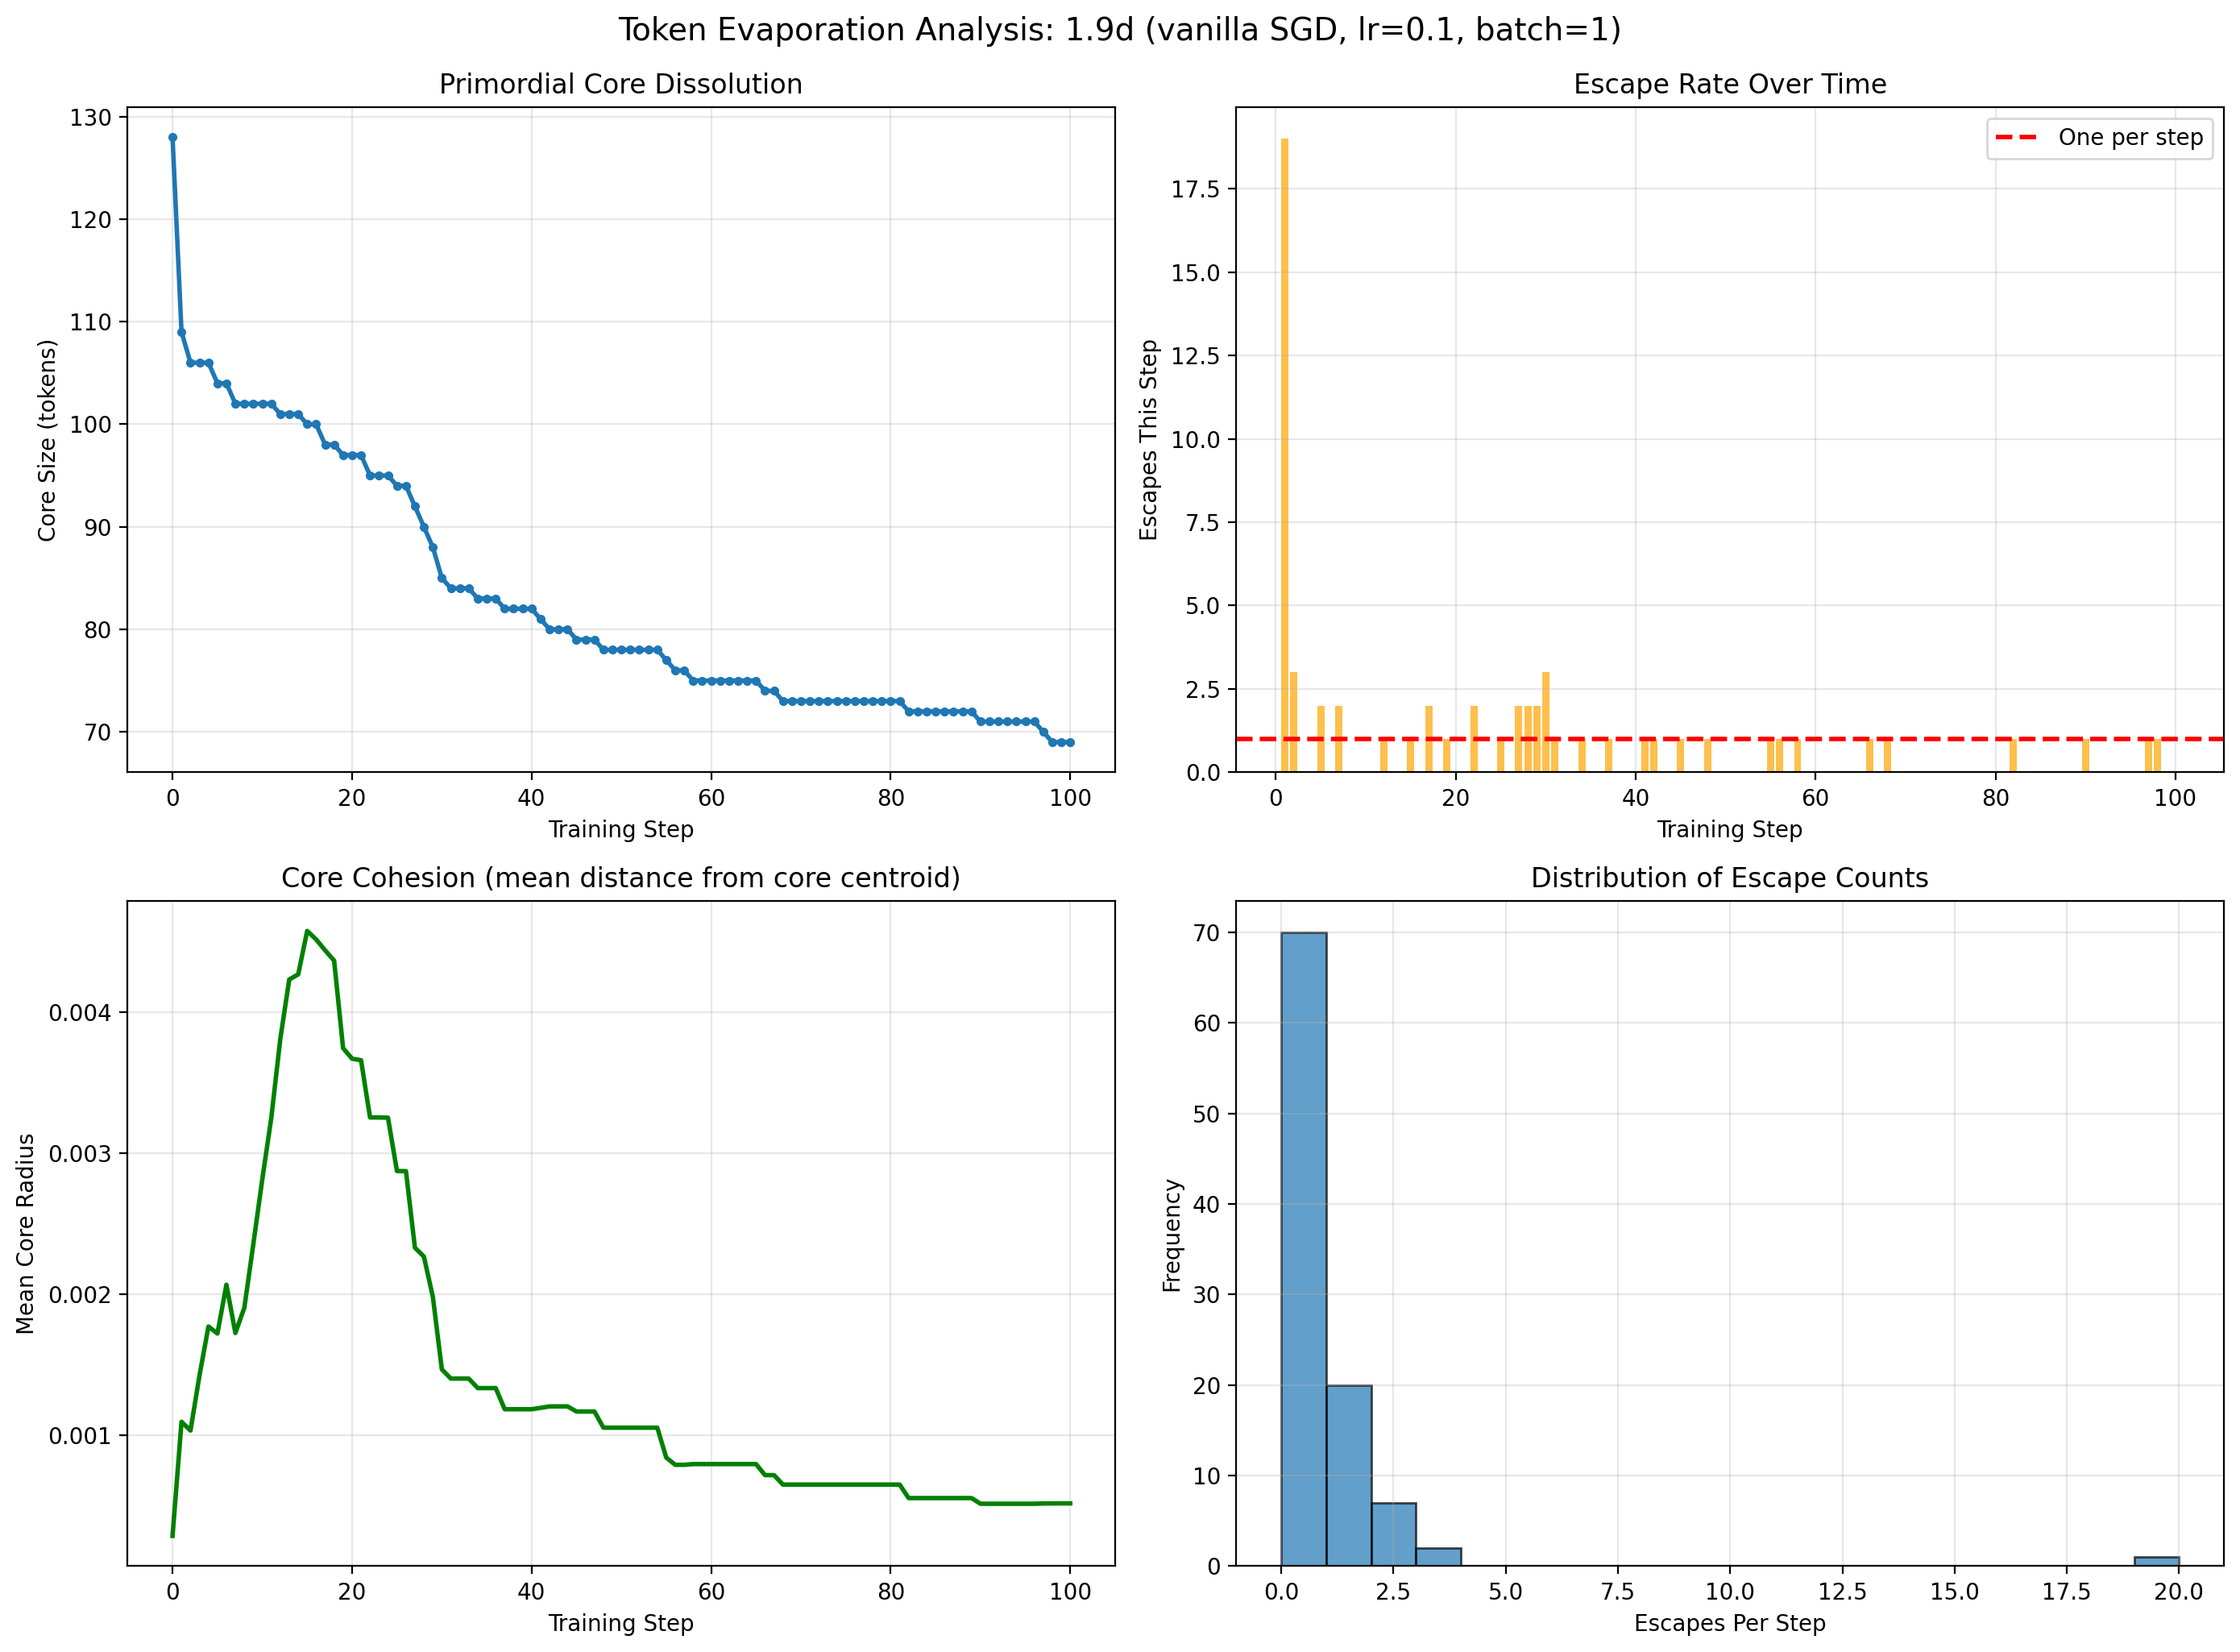

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)

# Top-left: Core size over time
ax = axes[0, 0]
ax.plot(ANALYSIS_STEPS, core_size_over_time, linewidth=2, marker='o', markersize=3)
ax.set_xlabel('Training Step')
ax.set_ylabel('Core Size (tokens)')
ax.set_title('Primordial Core Dissolution')
ax.grid(alpha=0.3)

# Top-right: Escapes per step
ax = axes[0, 1]
ax.bar(ANALYSIS_STEPS[1:], escapes_per_step[1:], color='orange', alpha=0.7)
ax.axhline(1, color='r', linestyle='--', linewidth=2, label='One per step')
ax.set_xlabel('Training Step')
ax.set_ylabel('Escapes This Step')
ax.set_title('Escape Rate Over Time')
ax.legend()
ax.grid(alpha=0.3)

# Bottom-left: Core radius over time
ax = axes[1, 0]
ax.plot(ANALYSIS_STEPS, core_radius_over_time, linewidth=2, color='green')
ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Core Radius')
ax.set_title('Core Cohesion (mean distance from core centroid)')
ax.grid(alpha=0.3)

# Bottom-right: Histogram of escapes per step
ax = axes[1, 1]
ax.hist(escapes_nonzero, bins=range(0, int(escapes_nonzero.max())+2), 
        edgecolor='black', alpha=0.7)
ax.set_xlabel('Escapes Per Step')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Escape Counts')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Token Evaporation Analysis: {RUN_NAME}', y=1.02, fontsize=14)
plt.show()

## Hypothesis Test: "One Token Per Step"

In [59]:
print('='*70)
print('HYPOTHESIS TEST: "Right Token Gets Kicked Each Step"')
print('='*70)
print()

# Prediction: If each step trains on one position, we expect:
# - Exactly 1 escape per step (the correct token for that position)
# - Regular, predictable pattern

one_escape_fraction = one_per_step_count / len(escapes_nonzero)
zero_escape_fraction = zero_per_step_count / len(escapes_nonzero)
multi_escape_fraction = multi_per_step_count / len(escapes_nonzero)

print(f'Fraction of steps with exactly 1 escape: {one_escape_fraction:.1%}')
print(f'Fraction of steps with 0 escapes: {zero_escape_fraction:.1%}')
print(f'Fraction of steps with >1 escape: {multi_escape_fraction:.1%}')
print()

if one_escape_fraction > 0.8:
    print('✓ HYPOTHESIS SUPPORTED: Dominant pattern is one escape per step')
    print('  → Training appears to be "kicking" one token at a time')
    print('  → Consistent with deterministic gradient updates')
elif zero_escape_fraction > 0.5:
    print('✗ HYPOTHESIS REJECTED: Most steps have NO escapes')
    print('  → Threshold may be too high, or core is very stable')
    print('  → Consider lowering L2_THRESHOLD')
elif multi_escape_fraction > 0.5:
    print('✗ HYPOTHESIS REJECTED: Most steps have MULTIPLE escapes')
    print('  → Training appears to affect many tokens per step')
    print('  → Suggests thermal/stochastic behavior')
else:
    print('~ HYPOTHESIS INCONCLUSIVE: Mixed pattern')
    print('  → Some one-at-a-time, some multi-escape')
    print('  → May indicate transitional regime')

print('='*70)

HYPOTHESIS TEST: "Right Token Gets Kicked Each Step"

Fraction of steps with exactly 1 escape: 20.0%
Fraction of steps with 0 escapes: 70.0%
Fraction of steps with >1 escape: 10.0%

✗ HYPOTHESIS REJECTED: Most steps have NO escapes
  → Threshold may be too high, or core is very stable
  → Consider lowering L2_THRESHOLD


## Core Stability Analysis

In [60]:
# Does the core stay coherent, or does it fragment?
# If core radius stays small while size decreases → orderly sublimation
# If core radius grows → core is fragmenting/expanding

print('='*70)
print('CORE STABILITY')
print('='*70)
print()

# Compare initial and final core radius
initial_radius = core_radius_over_time[0]
# Find last valid radius (before core is empty)
valid_radii = [r for r in core_radius_over_time if not np.isnan(r)]
if len(valid_radii) > 0:
    final_radius = valid_radii[-1]
    
    print(f'Initial core radius: {initial_radius:.6f}')
    print(f'Final core radius: {final_radius:.6f}')
    print(f'Change: {final_radius - initial_radius:+.6f}')
    print()
    
    if final_radius < initial_radius * 2:
        print('✓ CORE STABLE: Radius stayed small')
        print('  → Tokens sublimating from outside, core remains coherent')
    elif final_radius > initial_radius * 10:
        print('✗ CORE FRAGMENTING: Radius grew significantly')
        print('  → Even remaining tokens are drifting apart')
    else:
        print('~ CORE MODERATELY EXPANDING')
        print('  → Some expansion, but not extreme fragmentation')
else:
    print('Core fully dissolved (all tokens escaped)')

print('='*70)

CORE STABILITY

Initial core radius: 0.000285
Final core radius: 0.000515
Change: +0.000230

✓ CORE STABLE: Radius stayed small
  → Tokens sublimating from outside, core remains coherent
